In [ ]:
## reset specific variables (replace regular_expression by the variables of interest)
#%reset_selective <regular_expression>

# reset all variables
%reset -f

In [167]:
## Importing libraries

from datetime import datetime, date, timedelta
from array import *
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from pylab import savefig
import seaborn as sns
import pandas as pd
import csv
import json
import datetime as dt
from pymongo import MongoClient
from mongoengine import *
import time
import math
from scipy import stats
from scipy.stats._continuous_distns import _distn_names as dt_names
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")


ksN = 100          # Kolmogorov-Smirnov KS test for goodness of fit: samples
ALPHA = 0.05 


In [157]:
## Changing the distribution variable name to some much more intuitive
#distributions = dt_names

#len(dt_names)
from scipy.stats import (
    norm, beta, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    )


distributions = [
    norm, beta, expon, gamma, genextreme, logistic, lognorm, triang, uniform, fatiguelife,            
    gengamma, gennorm, dweibull, dgamma, gumbel_r, powernorm, rayleigh, weibull_max, weibull_min, 
    laplace, alpha, genexpon, bradford, betaprime, burr, fisk, genpareto, hypsecant, 
    halfnorm, halflogistic, invgauss, invgamma, levy, loglaplace, loggamma, maxwell, 
    mielke, ncx2, ncf, nct, nakagami, pareto, lomax, powerlognorm, powerlaw, rice, 
    semicircular, trapezoid, rice, invweibull, foldnorm, foldcauchy, cosine, exponpow, 
    exponweib, wald, wrapcauchy, truncexpon, truncnorm, t, rdist
    ]

In [210]:
## reading csv failure time file and converting data to float and 1-D numpy array

with open('MergeSSDs_FailureTimesAppWS.csv', newline='') as f:
    reader = csv.reader(f)
    data = list(reader)

for i in range(0, len(data)):
    data[i] = float((data[i])[0])

data = np.array(data)
data = np.ceil(data) # making the failure tags more readable

# Saving file for external analysis
df_data = pd.DataFrame(data)
df_data.to_csv('MergeSSDs_FailureTimesAppWSFixed.csv')

In [162]:
## Generating synthetic random variables following a specific statistical distribution

shp, loc, scl = 1.5, 0, 50000

rv = weibull_min(c=shp, loc=loc, scale=scl)

data = rv.rvs(1000)

In [188]:
# KS test for goodness of fit

def kstest(data, distname, paramtup):
    ks = stats.kstest(data, distname, paramtup, ksN)[1]   # return p-value
    return ks             # return p-value

In [189]:
# distribution fitter and call to KS test

def fitdist(data, dist):    
    fitted = dist.fit(data)
    ks = kstest(data, dist.name, fitted)
    res = (dist.name, ks, *fitted)
    return res

In [190]:
# call fitting function for all distributions in list
res = [fitdist(data,D) for D in distributions]

# convert the fitted list of tuples to dataframe
pd.options.display.float_format = '{:,.3f}'.format
df = pd.DataFrame(res, columns=["distribution", "KS p-value", "param1", "param2", "param3", "param4", "param5"])
df["distobj"] = distributions
df.sort_values(by=["KS p-value"], inplace=True, ascending=False)
df.reset_index(inplace=True)
df.drop("index", axis=1, inplace=True)
df

,distribution,KS p-value,param1,param2,param3,param4,param5,distobj
0,gumbel_r,0.829,"6,294.939","3,259.187",NaN,NaN,NaN,<scipy.stats._continuous_distns.gumbel_r_gen o...
1,maxwell,0.716,-919.853,"5,625.269",NaN,NaN,NaN,<scipy.stats._continuous_distns.maxwell_gen ob...
2,triang,0.614,0.353,-269.741,"18,809.737",NaN,NaN,<scipy.stats._continuous_distns.triang_gen obj...
3,beta,0.604,6.647,24.375,"-2,955.149","51,488.288",NaN,<scipy.stats._continuous_distns.beta_gen objec...
4,gamma,0.604,12.863,"-5,364.797","1,044.950",NaN,NaN,<scipy.stats._continuous_distns.gamma_gen obje...
...,...,...,...,...,...,...,...,...
56,rice,0.000,1.305,"-1,741.005",0.000,NaN,NaN,<scipy.stats._continuous_distns.rice_gen objec...
57,rice,0.000,1.305,"-1,741.005",0.000,NaN,NaN,<scipy.stats._continuous_distns.rice_gen objec...
58,foldnorm,0.000,1.305,"-1,741.005",0.000,NaN,NaN,<scipy.stats._continuous_distns.foldnorm_gen o...
59,exponpow,0.000,1.305,"-1,741.005",0.000,NaN,NaN,<scipy.stats._continuous_distns.exponpow_gen o...


In [154]:
def plot_fitted_pdf(df):
    
    N = len(df)
    chrows = math.ceil(N/3)                    # how many rows of charts if 3 in a row
    fig, ax = plt.subplots(chrows, 3, figsize=(20, 5 * chrows))
    ax = ax.ravel()
    dfRV = pd.DataFrame()

    for i in df.index:

        # D_row = df.iloc[i,:-1]
        D_name = df.iloc[i,0]
        D = df.iloc[i,7]
        KSp = df.iloc[i,1]
        params = df.iloc[i,2:7]    
        params = [p for p in params if ~np.isnan(p)]

        # calibrate x-axis by finding the 1% and 99% quantiles in percent point function
        x = np.linspace(
                    D.ppf(0.01, *params), 
                    D.ppf(0.99, *params), 100)

        #fig, ax = plt.subplots(1, 1)
        # plot histogram of actual observations
        ax[i].hist(data, density=True, histtype='stepfilled', alpha=0.2)
        # plot fitted distribution
        rv = D(*params)
        title = f'pdf {D_name}, with p(KS): {KSp:.2f}' 
        ax[i].plot(x, rv.pdf(x), 'r-', lw=2, label=title)
        ax[i].legend(loc="upper right", frameon=False)  

In [191]:
# from dataframe, select distributions with high KS p-value
df_ks = df.loc[df["KS p-value"] > ALPHA]
print(df_ks.shape)
print("Fitted Distributions with KS p-values > ALPHA:")
df_ks

(29, 8)
Fitted Distributions with KS p-values > ALPHA:


,distribution,KS p-value,param1,param2,param3,param4,param5,distobj
0,gumbel_r,0.829,"6,294.939","3,259.187",NaN,NaN,NaN,<scipy.stats._continuous_distns.gumbel_r_gen o...
1,maxwell,0.716,-919.853,"5,625.269",NaN,NaN,NaN,<scipy.stats._continuous_distns.maxwell_gen ob...
2,triang,0.614,0.353,-269.741,"18,809.737",NaN,NaN,<scipy.stats._continuous_distns.triang_gen obj...
3,beta,0.604,6.647,24.375,"-2,955.149","51,488.288",NaN,<scipy.stats._continuous_distns.beta_gen objec...
4,gamma,0.604,12.863,"-5,364.797","1,044.950",NaN,NaN,<scipy.stats._continuous_distns.gamma_gen obje...
5,betaprime,0.604,13.097,"1,939.748","-5,438.084","2,000,529.448",NaN,<scipy.stats._continuous_distns.betaprime_gen ...
6,ncf,0.601,0.104,52.403,18.778,0.247,42.069,<scipy.stats._continuous_distns.ncf_gen object...
7,invgamma,0.595,48.287,"-17,499.179","1,209,273.174",NaN,NaN,<scipy.stats._continuous_distns.invgamma_gen o...
8,powernorm,0.565,0.071,"2,451.167","1,380.041",NaN,NaN,<scipy.stats._continuous_distns.powernorm_gen ...
9,nakagami,0.560,1.776,"-1,575.786","10,351.982",NaN,NaN,<scipy.stats._continuous_distns.nakagami_gen o...


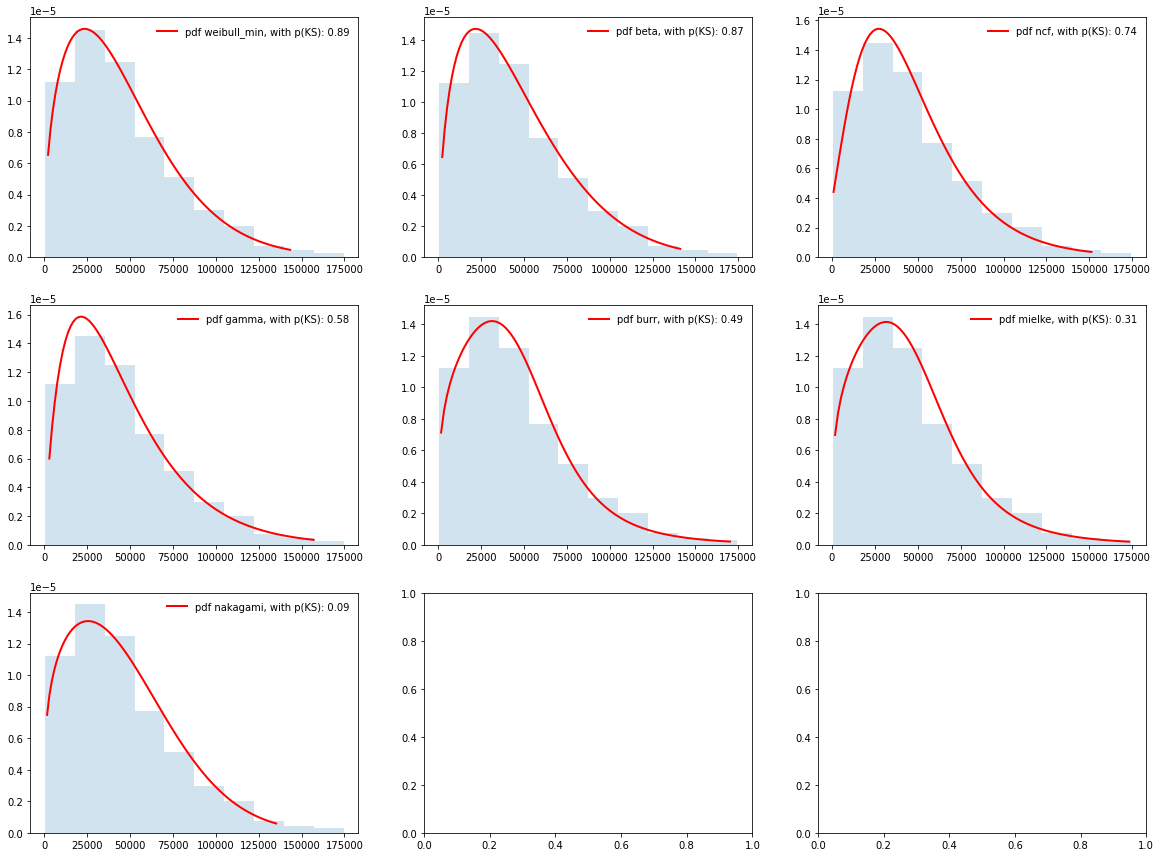

In [144]:
# call the plotting function
plot_fitted_pdf(df_ks)
pass

In [145]:
# fitted distribution with highest p-value of KS test
D_opt = df_ks.loc[df_ks["KS p-value"].idxmax()]
# D_opt[:-1]

D_opt

distribution                                          weibull_min
KS p-value                                                  0.889
param1                                                      1.474
param2                                                      0.000
param3                                                 50,866.032
param4                                                        NaN
param5                                                        NaN
distobj         <scipy.stats._continuous_distns.weibull_min_ge...
Name: 0, dtype: object

In [ ]:
# script takes this best fitting distribution and begins to works with it:
# parameters

print(D_opt.iloc[0])            # name
DO = D_opt.iloc[7]              # distribution object

params = D_opt.iloc[2:7]    
params = [p for p in params if ~np.isnan(p)]
params

In [ ]:
# statistics of the best fitting distribution (4 moments)
stats = DO.stats(*params, "mvsk")
stat_names = ["mean", "variance", "skew", "kurtosis"]
dict_stats = {k:v for k,v in zip(stat_names, stats)} 
_ = [print(k,":",f'{v:.4f}') for k,v in dict_stats.items()]

In [ ]:
# CDF of a chosen x, here the mean
x = dict_stats["mean"]
cdfx = DO.cdf(x, *params)
cdfx

In [ ]:
## EXAMPLE

# mean time to failure
print(f'{rv.mean():.0f}')

In [ ]:
## EXAMPLE

T = 20000

cdfT = rv.cdf(T)           # cumulative failure rate after T hours

svfT = 1 - cdfT
svfT = rv.sf(T)

dict_f = {"at hours":T, "% cumulative failures":cdfT, "surviving % of all components":svfT}
_ = [print(k,":",f'{v:.3f}') for k,v in dict_f.items()]
# svf % of all components will last at least T hours

In [ ]:
## EXAMPLE

# time to a cumulative failure rate of 1%

q = 0.01
ppfq = rv.ppf(q)           

print(f'{ppfq:.0f}', "hours")

In [ ]:
## EXAMPLE
# properties of the beta distribution

a, b = 2, 6

x = beta.rvs(a, b, size=1000)

fig, ax = plt.subplots(1, 1)
ax.hist(x, density=True, histtype='stepfilled', alpha=0.2)
ax.legend(loc='best', frameon=False)
plt.show()
pass

In [ ]:
## EXAMPLE
# statistics of the Beta(2,6) distribution
m = beta.mean(a,b)
v = beta.var(a,b)
shp_a = beta.a
shp_b = beta.b
median = beta.median(a,b)

dict_stats = {"mean":m, "var":v, "shape a":shp_a, "shape b":shp_b, "median":median}
_ = [print(k,":",f'{v:.3f}') for k,v in dict_stats.items()]

In [ ]:
## EXAMPLE
# plot the pdf
x = np.linspace(rv.ppf(0.01),
                rv.ppf(0.99), 100)

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.pdf(x), 'r-', lw=5, alpha=0.6, label='beta pdf')
pass

In [ ]:
## EXAMPLE
# plot the cdf

fig, ax = plt.subplots(1, 1)
ax.plot(x, rv.cdf(x), 'r-', lw=5, alpha=0.6, label='beta cdf')
pass

In [ ]:
## EXAMPLE
# plot the inverse cdf or ppf

q = np.linspace(0.0, 1.0, 100)

fig, ax = plt.subplots(1, 1)
ax.plot(q, rv.ppf(q), 'r-', lw=5, alpha=0.6, label='beta inverse cdf')
pass